# Suport Vector Machine classifies River Morphology

Understand how to use Suport Vector Machine to classify river bed morphology



+ **Dataset source:** https://en.bedloadweb.com/
   




## Import packages and load data

In [1]:
import pandas as pd

data= pd.read_csv("bedload_dataset")
data


,W,S,Q,U,H,Morphology
0,65.23,0.004100,319.98,2.90,1.69,Riffle-pool
1,3.30,0.018000,1.08,1.00,0.32,Riffle-pool
2,7.00,0.001500,3.96,0.73,0.78,Riffle-pool
3,166.12,0.000680,1124.18,1.78,3.81,Riffle-pool
4,8.38,0.013018,2.50,0.83,0.38,Riffle-pool
...,...,...,...,...,...,...
1062,102.00,0.000960,171.00,1.40,1.20,Braiding
1063,8.40,0.025000,3.34,1.20,0.33,Braiding
1064,101.00,0.000440,260.00,1.50,1.80,Braiding
1065,7.50,0.025000,2.15,0.96,0.30,Braiding


# Clean data
### Remove NaN values

In [2]:
# verify the type of data within the columns
print(data.info(),"\n")
    
# remove rows that contains at least on NaN value
print(data.dropna(inplace=True))

# verify that all NaN values are out
for column in data.columns.to_list():
    print(column,":",data[column].isnull().any())
    
# verify final number of rows (samples) 
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   W           1067 non-null   float64
 1   S           1067 non-null   float64
 2   Q           1067 non-null   float64
 3   U           1067 non-null   float64
 4   H           1067 non-null   float64
 5   Morphology  1067 non-null   object 
dtypes: float64(5), object(1)
memory usage: 50.1+ KB
None 

None
W : False
S : False
Q : False
U : False
H : False
Morphology : False
(1067, 6)


### Search for outliers

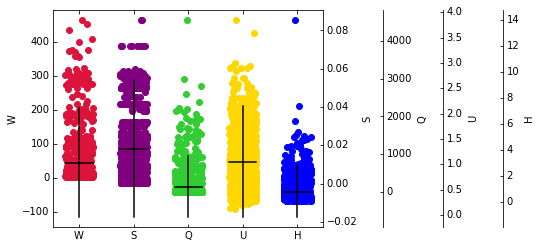

In [4]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# vizualize scatter of all features (predictors)
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

labels = data.columns[0:5].tolist()
colors = ["crimson", "purple", "limegreen", "gold", "blue"]

width=0.5

std_store = []
mean_store = []
for i, l in enumerate(labels):
    if i ==0:
        ax = host
        ax.set_ylabel(labels[i])
    else:        
        ax = host.twinx()
        new_fixed_axis = ax.get_grid_helper().new_fixed_axis
        ax.axis["right"] = new_fixed_axis(loc="right",
                                            axes=ax,
                                            offset=(60*(i-1), 0))
        ax.axis["right"].toggle(all=True)
        ax.set_ylabel(labels[i])

    x = np.ones(data.shape[0])*i + (np.random.rand(data.shape[0])*width-width/2.)
    ax.scatter(x, data[data.columns[i]],color=colors[i])
    mean = data[f"{data.columns[i]}"].mean()
    std = np.std(data[data.columns[i]])
    ax.plot([i-width/2., i+width/2.],[mean,mean], color="k")
    ax.plot([i,i], [mean-2*std, mean+2*std], color="k")    
        


ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

plt.draw()
plt.show()

### Remove outliers

+ the outliers can be identifyed by the specialist.
+ if it is not possible to have a unbiased opinion from the specialist about the outliers, zscore can be used.

In [5]:
from scipy.stats import zscore
# choose the method to remove outliers
# remove_method = "expert_analysis"
remove_method = "zscore"

if "expert" in remove_method:
    data = data.loc[(data["qs"]<0.02) &
                    (data["Q"]<2000) &
                    (data["W"]<250)]
else:
    data = data[(np.abs(zscore(data.loc[:,data.columns!="Morphology"])) < 4).all(axis=1)]
    
data

,W,S,Q,U,H,Morphology
0,65.23,0.004100,319.98,2.90,1.69,Riffle-pool
1,3.30,0.018000,1.08,1.00,0.32,Riffle-pool
2,7.00,0.001500,3.96,0.73,0.78,Riffle-pool
3,166.12,0.000680,1124.18,1.78,3.81,Riffle-pool
4,8.38,0.013018,2.50,0.83,0.38,Riffle-pool
...,...,...,...,...,...,...
1062,102.00,0.000960,171.00,1.40,1.20,Braiding
1063,8.40,0.025000,3.34,1.20,0.33,Braiding
1064,101.00,0.000440,260.00,1.50,1.80,Braiding
1065,7.50,0.025000,2.15,0.96,0.30,Braiding


### Verify classes proportions
+ It is importanat to have a representatice number of samples for each class
+ the minimun number of samples for each class depends on the type of the problem. In general terms, the more unique are the characteristics of a class, the less samples are needed. 
+ (a problem to removing classes) Creating a model that does not contemplate all the classes of a system will be limited of classifing samples within the limits of classes given. Thus, removing classes from the training procces is not recomended. Ideally, all classes have a large number of traning samples and they are similar in quantity.
+ note thar the class 'Sand bed' is underrepresented, when compared to the others. A dispropostional ratio can afferct the performace of the model on the underrepresented class, because the ml model may not capture the correlation between this classes and the features.

In [6]:
data["Morphology"].value_counts()

Step-pool      247
Plane Bed      243
Riffle-pool    241
Braiding       228
Sand bed        79
Name: Morphology, dtype: int64

# Derive new predictors

+ Sometimes it is possible to derive new meaniful new features from the existing ones.
+ in the example: 
 + the product of slope S (-), velocity U (m/s), and Depth H  (m)
 + the ratio of discharge (m³/s) and width (m) (i.e. Q/W)
+ rise the problem of correlated predictors



In [7]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# compute new columns for the new features SUH and Q/W
data["SUH"] = (data.loc[:,"S"]*data.loc[:,"U"]*data.loc[:,"H"])
data["Q/W"] = (data.loc[:,"Q"]/data.loc[:,"W"])
data

,W,S,Q,U,H,Morphology,SUH,Q/W
0,65.23,0.004100,319.98,2.90,1.69,Riffle-pool,0.020094,4.905412
1,3.30,0.018000,1.08,1.00,0.32,Riffle-pool,0.005760,0.327273
2,7.00,0.001500,3.96,0.73,0.78,Riffle-pool,0.000854,0.565714
3,166.12,0.000680,1124.18,1.78,3.81,Riffle-pool,0.004612,6.767277
4,8.38,0.013018,2.50,0.83,0.38,Riffle-pool,0.004106,0.298329
...,...,...,...,...,...,...,...,...
1062,102.00,0.000960,171.00,1.40,1.20,Braiding,0.001613,1.676471
1063,8.40,0.025000,3.34,1.20,0.33,Braiding,0.009900,0.397619
1064,101.00,0.000440,260.00,1.50,1.80,Braiding,0.001188,2.574257
1065,7.50,0.025000,2.15,0.96,0.30,Braiding,0.007200,0.286667


### Verify colinearity
+ Multicollinearyty may not be a problem. However, variable importance analysis is not reliable whe correlated feactures are used. The weight of a model may not represent correctly the importance of the feature (verify this statment)
+ One tool that can measure level of correlation can be the variance inflation factor.
+ Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated, we might have difficulty in distinguishing between their individual effects on the dependent variable. Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).
+ What is the limits for VIF?
+ Explain how id VIF is computed. 
+ seaborn is a matplotlib based library addepted to ml analysis.

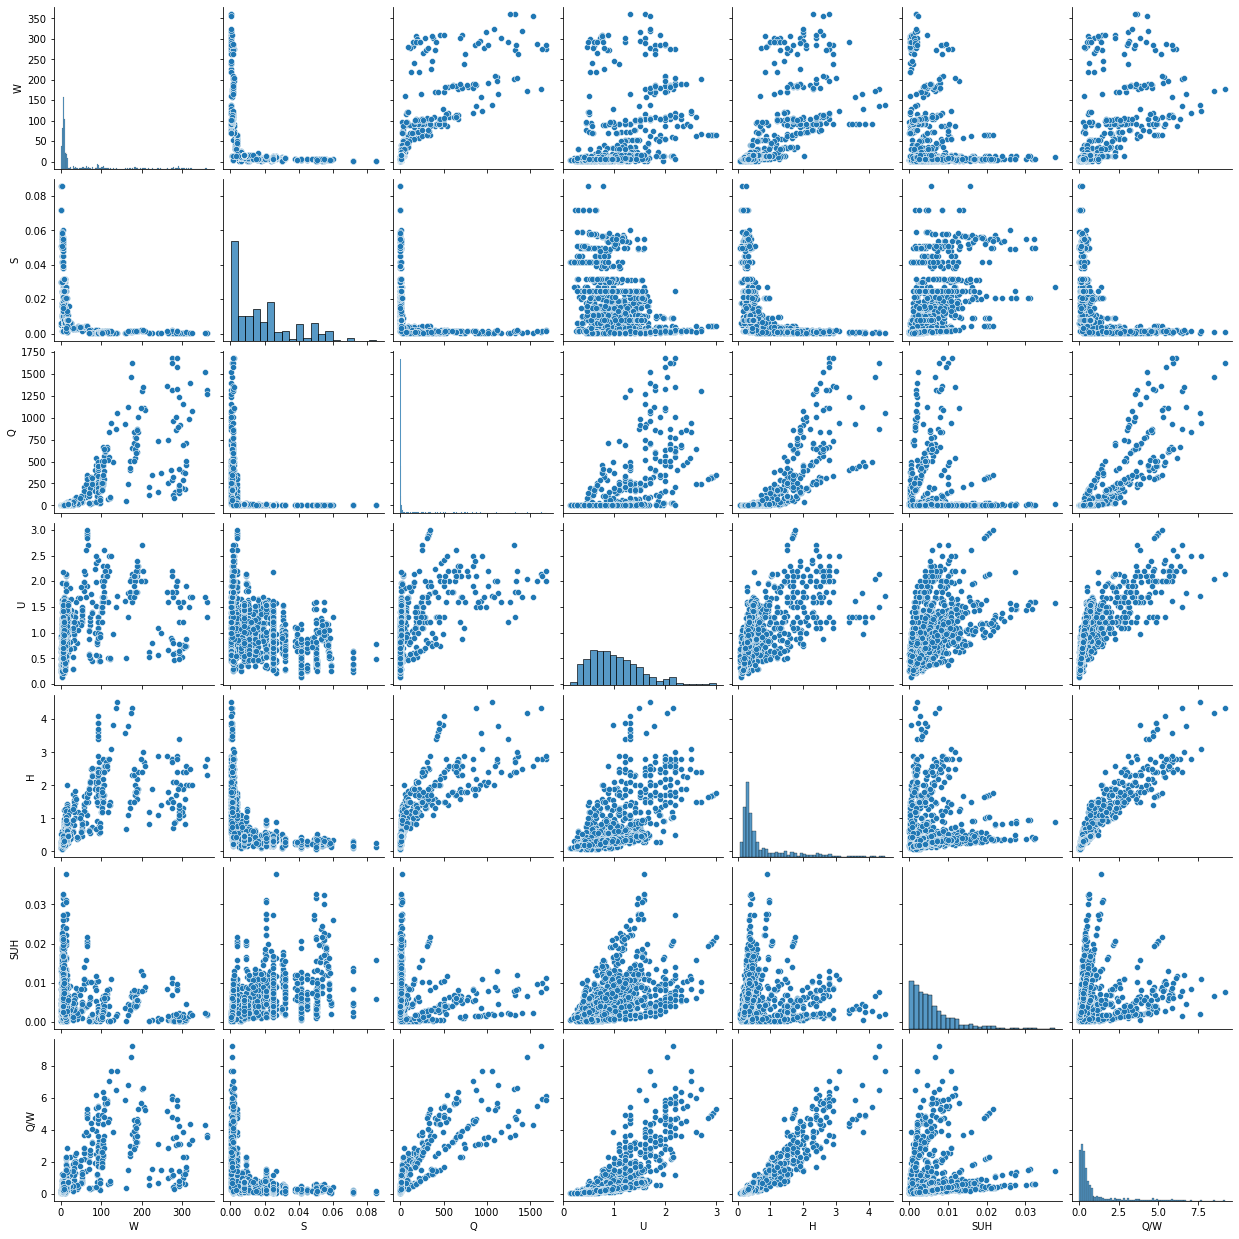

In [8]:
import seaborn as sns

# plot scatters of the 2d (two dimensinal) combinaiton of features
sns.pairplot(data.loc[:,data.columns!="Morphology"])
plt.show()

In [9]:
# verify linear coorralation with pandas
data.loc[:,data.columns!="Morphology"].corr()

,W,S,Q,U,H,SUH,Q/W
W,1.000000,-0.443053,0.813299,0.372959,0.712785,-0.188685,0.632963
S,-0.443053,1.000000,-0.359770,-0.395141,-0.528205,0.418188,-0.456156
Q,0.813299,-0.359770,1.000000,0.543418,0.818947,-0.046315,0.858403
U,0.372959,-0.395141,0.543418,1.000000,0.591484,0.435555,0.749569
H,0.712785,-0.528205,0.818947,0.591484,1.000000,-0.054656,0.930226
SUH,-0.188685,0.418188,-0.046315,0.435555,-0.054656,1.000000,0.082214
Q/W,0.632963,-0.456156,0.858403,0.749569,0.930226,0.082214,1.000000


In [10]:
from sklearn.linear_model import LinearRegression

# compute VIF for the features
def calculate_vif(df, features):
    vif, tolerance = {}, {}
    
    for feature in features:        
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]
        X, y = df[X], df[feature]
        
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif[feature] = 1 / (1 - r2)
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif})

# call fuction calculate_vif with features as input
calculate_vif(df=data, 
              features=data.columns[data.columns != "Morphology"].to_list())




,VIF
H,14.721236
Q,9.278038
Q/W,27.648327
S,2.983335
SUH,3.028896
U,6.515027
W,4.691707


### remove correlated features
+ Q is alredy a variable insie Q/W and H will be "represented" Q/W
+ Why it make sense remove H?

In [11]:
# try and error approach removing features get VIFs < 10 
data = data.loc[:, data.columns[(data.columns !="H")&
                                (data.columns !="Q")
                               ]
               ]

# compute VIF again to verify if VIFs are less than 10
calculate_vif(df=data, 
              features=data.columns[data.columns != "Morphology"].to_list())


,VIF
Q/W,3.628840
S,2.451387
SUH,2.855595
U,4.778947
W,1.872494


# Split training and testing sets

In [12]:
from sklearn.model_selection import train_test_split 


# split dataframes with features and labels only
labels = data.loc[:, "Morphology"]
predictors = data.loc[:, data.columns[data.columns != "Morphology"]]

# split testing set as 33% of the data
# X correspond to the featues (matrix form)
# y corresponf to the labels (vector form)
X_train, X_test, y_train, y_test = train_test_split(predictors,  
                                                    labels,
                                                    test_size=0.3, 
                                                    random_state=42 # seed for random selection of data
                                                   )

# visualize training and testing sets
print("TRAINING DATASET PREDICTORS")
print(X_train.head(), "\n")
print("dataframe size", X_train.shape,"\n")
print("------------------------------------------")
print("TRAINING DATASET TARGET")
print(y_train,"\n")
print()
print("------------------------------------------------------------------------------------\n")

print("TESTING DATASET PREDICTORS")
print(X_test.head())
print("dataframe size", X_test.shape,"\n")
print("------------------------------------------")
print("TESTING DATASET TARGET")
print(y_test.head())
print("Vector size", y_test.shape)


TRAINING DATASET PREDICTORS
          W        S     U       SUH       Q/W
256    6.91  0.01100  1.02  0.003366  0.277858
397   88.09  0.00210  1.99  0.008149  3.889545
586   14.02  0.02070  1.34  0.022190  1.078459
526  218.00  0.00041  0.52  0.000175  0.541284
9      8.00  0.02000  1.18  0.007316  0.370000 

dataframe size (726, 5) 

------------------------------------------
TRAINING DATASET TARGET
256      Plane Bed
397      Plane Bed
586      Step-pool
526       Sand bed
9      Riffle-pool
          ...     
89     Riffle-pool
337      Plane Bed
476      Plane Bed
123    Riffle-pool
876       Braiding
Name: Morphology, Length: 726, dtype: object 


------------------------------------------------------------------------------------

TESTING DATASET PREDICTORS
          W        S     U       SUH       Q/W
203    2.57  0.01040  1.58  0.008216  0.793774
937  105.00  0.00096  1.90  0.002918  3.076190
546   93.00  0.00050  1.10  0.001320  2.688172
214   53.04  0.00380  1.44  0.004596 

## k-fold Cross Validation

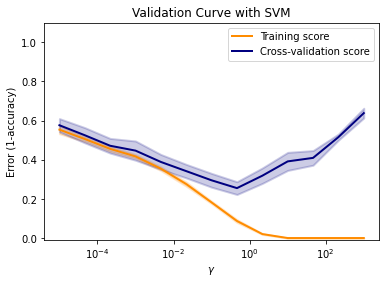

In [13]:
from sklearn.svm import SVC 
from sklearn.model_selection import validation_curve 


# define possible parameters combination
param_range = np.logspace(-5, 3, 13) # range of alpha parameter
C=500 # chosen hyperparameter through tunnig

# Peform 5-fold cross-validation and save training and validation error
train_scores, test_scores = validation_curve(SVC(C=C),
                                             X_train,
                                             y_train,
                                             param_name="gamma",
                                             param_range=param_range,
                                             scoring="accuracy",
                                             cv=5
                                            )

# convert accuracy into error
train_error = 1-train_scores
validation_error = 1-test_scores

# compute 5-fold cross-validation mean and std of error 
train_error_mean = np.mean(train_error, axis=1)
train_error_std = np.std(train_error, axis=1)
validation_error_mean = np.mean(validation_error, axis=1)
validation_error_std = np.std(validation_error, axis=1)

# train and validation error vizualisation
plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Error (1-accuracy)")
plt.ylim(-0.01, 1.1)
lw = 2
plt.semilogx(
    param_range, train_error_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_error_mean - train_error_std,
    train_error_mean + train_error_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, validation_error_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    validation_error_mean - validation_error_std,
    validation_error_mean + validation_error_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

## Choose optimal parameter


In [14]:
# save optimal gamma
index_min = min(range(len(validation_error_mean)), key=validation_error_mean.__getitem__)
validation_error_min = validation_error_mean[index_min]
gamma_opt = param_range[index_min] # gamma that gives minimun validation error

# visualize error evolution with gamma 
columns = ["Mean validation error","gamma"]
array = np.array([validation_error_mean, param_range]).transpose()

print( pd.DataFrame(array,columns=columns), "\n")
print("Minimun mean validation error:", validation_error_min)
print("optimal gamma:", gamma_opt)

    Mean validation error        gamma
0                0.575739     0.000010
1                0.524856     0.000046
2                0.471101     0.000215
3                0.446311     0.001000
4                0.388474     0.004642
5                0.341606     0.021544
6                0.294709     0.100000
7                0.254861     0.464159
8                0.318262     2.154435
9                0.391252    10.000000
10               0.409173    46.415888
11               0.515144   215.443469
12               0.637789  1000.000000 

Minimun mean validation error: 0.2548606518658479
optimal gamma: 0.46415888336127725


## Train the optimal hypothesis model

In [15]:
# train optimal model and evaluate accuracy 
h_opt = SVC(gamma=gamma_opt,C=C) # instiate optimal model 
h_opt.fit(X_train,y_train) # train the model to the entire training set
print("Error (1-Accuracy) of h_opt on testing data: \n -->>",1- h_opt.score(X_test,y_test)) 

Error (1-Accuracy) of h_opt on testing data: 
 -->> 0.19551282051282048


## Performance evaluation

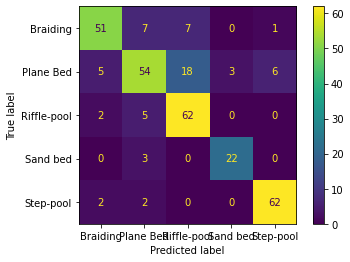

In [16]:
from sklearn.metrics import plot_confusion_matrix 

#plot confution Matrix
plot_confusion_matrix(h_opt, # trained optimal hypothesis model
                      X_test, 
                      y_test,
                     )
plt.show()